# Truly understanding sampling-based motion planning

This project is intended to make you truly understand and appreciate why sampling-based motion planning algorithms have become the dominant paradigm in robotics. You will also see its drawbacks, and that it is not the solution to motion planning problems. You will implement several sampling-based algorithms and answer a series of questions that test your understanding of motion planning algorithms. Your grades will depend on the depth of your understanding. Good luck!


## Part 0: Environment creation

The goal of robot is to reach the goal position (cyan) from the start position (white) without hitting the obstacles (blue).

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


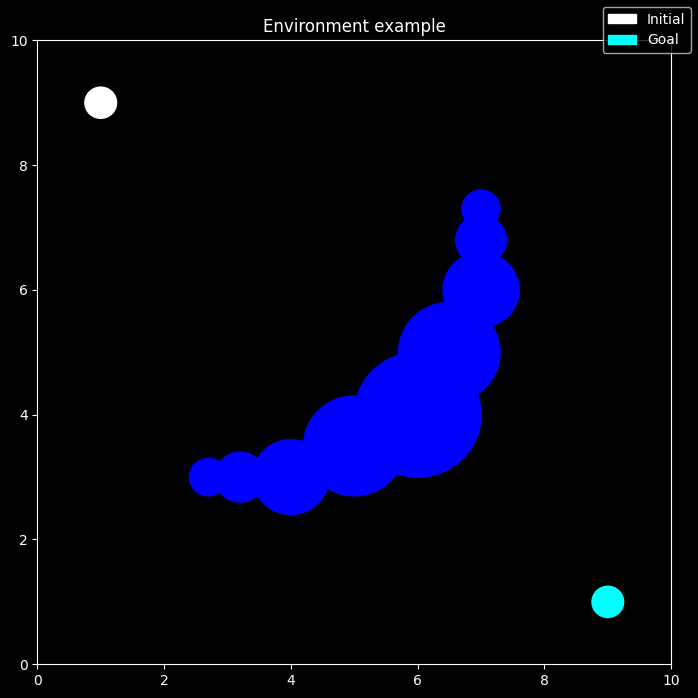

In [14]:
%load_ext autoreload
%autoreload 2

from common import State, Node, Tree, Object, Robot, Environment, GIFGenerator
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from tqdm.notebook import tqdm

plt.ioff()

env = Environment.dummy()
fig = env.draw(show=True, title="Environment example")


## 1.0 Exploration and exploitation

### 1.1: An alternative sampling-based algorithm

Implement the following sampling-based algorithm:
1. Initialize a tree with an initial configuration
2. Select a random node from the tree, called $x_{tree}$
3. Select a random configuration, called $x_{rand}$, from the collision-free configuration space
4. Extend from $x_{tree}$ to $x_{rand}$
5. Add the new nodes from the extend operation to the tree
6. If a goal configuration is added to the tree, terminate. Solution found!
7. Otherwise, go to step 2 

Visualize its tree-growing procedure, like this [video](https://www.youtube.com/watch?v=YKiQTJpPFkA).


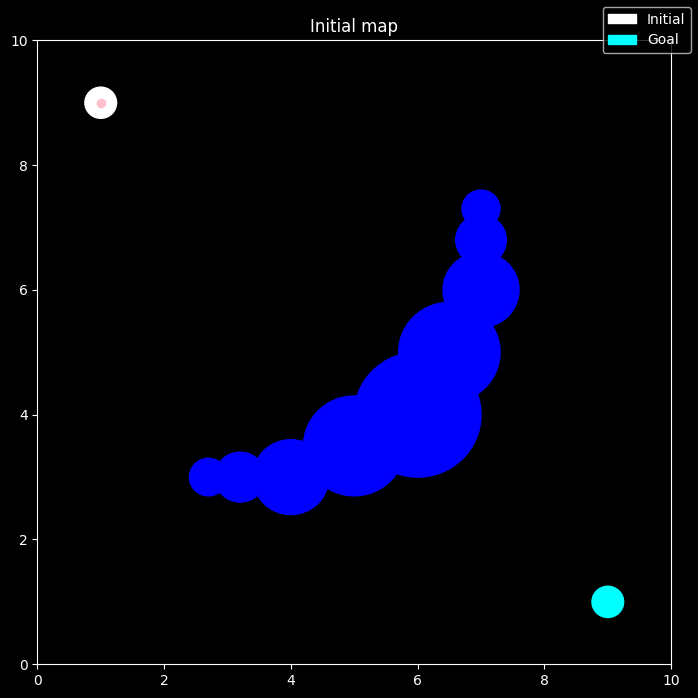

  0%|          | 0/1000 [00:00<?, ?it/s]

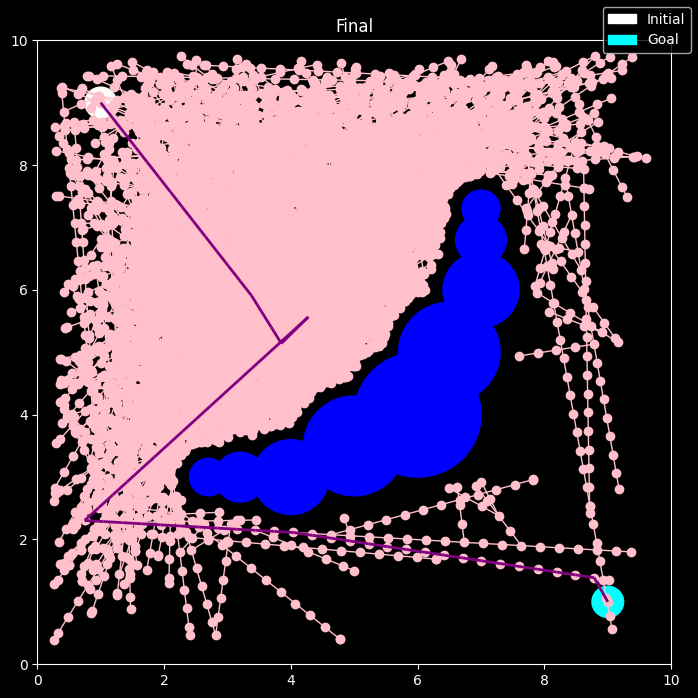

Saved GIF to 1.1.gif


In [21]:
class NaiveSolver:
    def __init__(self, tree: Tree, env: Environment, robot: Robot, step_size: float = 0.1, max_iter: int = 1000, gif_generator: GIFGenerator = None):
        self.tree = tree
        self.env = env
        self.robot = robot
        self.step_size = step_size
        self.max_iter = max_iter
        self.gif_generator = gif_generator

    def solve(self, save_every: int, save_path: str):
        found_path = None
        for i in tqdm(range(self.max_iter)):
            new_found_path = self.step()
            if new_found_path is not None:
                if found_path is None:
                    found_path = new_found_path
                elif len(new_found_path) < len(found_path):
                        found_path = new_found_path
                found_path = new_found_path
            fig = self.env.draw(self.tree, found_path, title=f"Iteration {i}", show=False)
            if i % save_every == 0 and self.gif_generator is not None:
                self.gif_generator.add_frame(fig)
            plt.close()

        self.env.draw(self.tree, found_path, title="Final", show=True)
        if self.gif_generator is not None and save_path is not None:
            self.gif_generator.save(save_path)
    
    def extend(self, tree_node: Node, rand_state: State):
        tree_state = tree_node.state
        distance = (tree_state - rand_state).norm()
        max_step = distance // self.step_size
        states = [
            tree_state + (rand_state - tree_state) / distance * self.step_size * (i + 1) for i in range(0, int(max_step))
        ] + [rand_state]
        valid_states = []
        for state in states:
            self.robot.set_state(state)
            if self.env.check_collision(self.robot):
                break
            valid_states.append(state)

        parent = tree_node
        new_nodes = []
        for state in valid_states:
            node = Node(state, parent)
            self.tree.add(node)
            parent = node
            new_nodes.append(node)
        return new_nodes

    def check_goal(self, nodes: list[Node]):
        for node in nodes:
            self.robot.set_state(node.state)
            if self.env.reached_goal(self.robot):
                return node
        return None

    def step(self):
        def select_random_node(nodes):
            return random.choice(nodes)

        rand_state = self.env.generate_random_state(self.robot)
        tree_node = self.tree.select_node(policy=select_random_node)
        new_nodes = self.extend(tree_node, rand_state)
        dest_node =  self.check_goal(new_nodes)
        if dest_node is not None:
            return self.tree.get_path(dest_node)
        return None

gif_generator = GIFGenerator()
env = Environment.dummy()
init_state, goal_state = env.init_state, env.goal_state
tree = Tree(init_state)
env.draw(tree, title="Initial map", show=True)

solver = NaiveSolver(tree, env, Robot(0.25, State(1, 1)), step_size=0.3, max_iter=1000, gif_generator=gif_generator)
solver.solve(10, "1.1.gif")

Answer the following questions:
1. Prove that this algorithm is probabilistically complete or not

**Lemma 1.** Suppose $Q_{free}$ is a convex, bounded, open, n-dimensional subset of an n-dimensional configuration space. Let $D_k(q)$ be the random variable whose value is the distance of q to the closest vertex in G and $d_k(q)$ be the value of $D_k(q)$. Then, for any $q \in Q_{free}$, and any $\epsilon > 0$, the probability that $d_k(q) \leq \epsilon$ approaches 1 as k approaches infinity.

**Proof)**

Let $B(q)$ be the ball of radius $\epsilon$ centered at q. Then, the probability that $q$ is in $B(q)$ is 1.
$B'(q)$ is intersection of $B(q)$ and $Q_{free}$. Since $B'(q)$ is not empty, probability that $d_k(q) \leq \epsilon$ is $1 - (1 - \frac{\mu(B'(q))}{\mu(Q_{free})})^k$. $\mu$ is the measure of the set. 
So, the probability that $d_k(q) \leq \epsilon$ approaches 1 as k approaches infinity.

**Lemma 2.** Suppose $Q_{free}$ is a non convex, bounded, open, n-dimensional subset of an n-dimensional configuration space. For any $q \in Q_{free}$, and any $\epsilon > 0$, the probability that $d_k(q) \leq \epsilon$ approaches 1 as k approaches infinity.

**Proof)**

Let $B(q)$ be the ball of radius $\epsilon$ centered at q. Since $Q_{free}$ is connected, sequence (q_0, q_1, ..., q_n) exists such that $q_0 = q$ and $q_n$ is q, $B(q_i) \cap B(q_{i+1})$ is not empty.

Assume that we have sampled points in $B(q_i)$, we can sample points in $B(q_{i+1})$. Since $B(q_i)$ is convex, by lemma 1, the probability of sampling points in $B(q_i) \cap B(q_{i+1})$ is 1 as k approaches infinity. By induction on i, the probability of sampling points in $B(q)$ is 1 as k approaches infinity.


By lemma 2, the algorithm is probabilistically complete because by extending the points between the $B(q_i) \cap B(q_{i+1})$, we can reach the goal configuration.

2. Comment on the tree-growth procedure. Does it efficiently explore the configuration space? Why or why not?

No, the tree-growth procedure does not efficiently explore the configuration space. By selecting a random node from the tree and extending to a random configuration, the tree grows in a random direction, which not guarantee to explore the unexplore area. This can be seen in the previous result too.


### 1.2: Exploiting domain knowledge

Implement the following alternative algorithm: instead of choosing a random node from the tree in line 2 of the algorithm given in part 1, choose the node with the least heuristic value defined by:
$$
x_{tree} = \argmin_{x \in V} \text{straight-line-distance-to-goal}(x)
$$
where V is the set of nodes in the current tree, and the straight-line-distance-to-goal function measures the straight-line distance to the goal from the given configuration x. Visualize its tree-growing procedure.

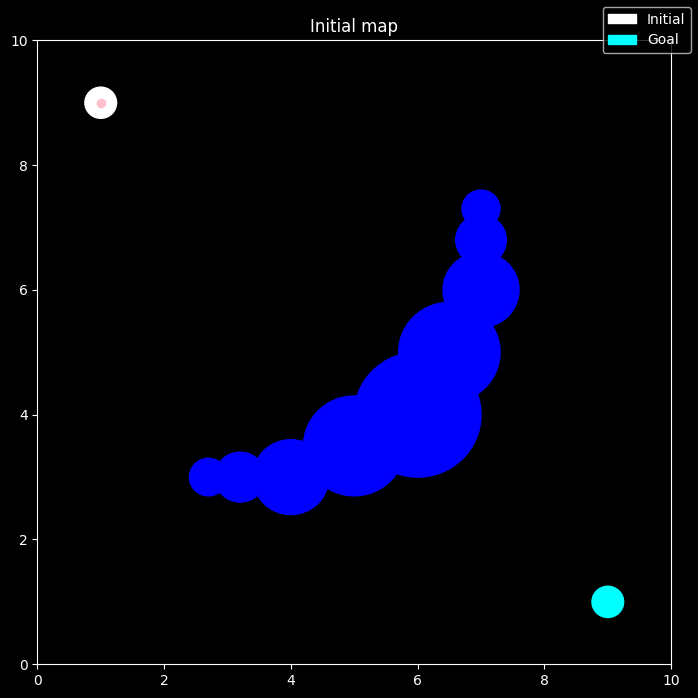

  0%|          | 0/1000 [00:00<?, ?it/s]

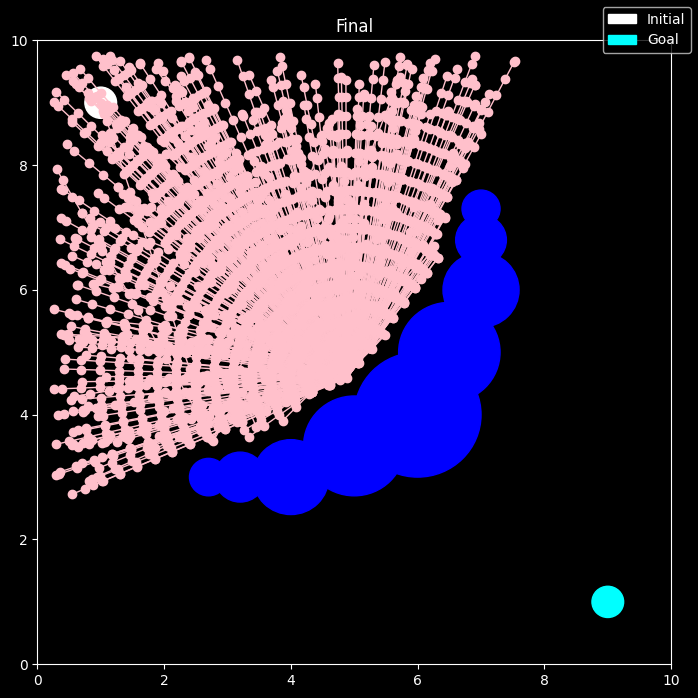

Saved GIF to 1.2.gif


In [19]:
class ExploitingDomainKnowledgeSolver:
    def __init__(self, tree: Tree, env: Environment, robot: Robot, step_size: float = 0.1, max_iter: int = 1000, gif_generator: GIFGenerator = None):
        self.tree = tree
        self.env = env
        self.robot = robot
        self.step_size = step_size
        self.max_iter = max_iter
        self.gif_generator = gif_generator

    def solve(self, save_every: int, save_path: str):
        found_path = None
        for i in tqdm(range(self.max_iter)):
            new_found_path = self.step()
            if new_found_path is not None:
                if found_path is None:
                    found_path = new_found_path
                elif len(new_found_path) < len(found_path):
                        found_path = new_found_path
                found_path = new_found_path
            fig = self.env.draw(self.tree, found_path, title=f"Iteration {i}", show=False)
            if i % save_every == 0 and self.gif_generator is not None:
                self.gif_generator.add_frame(fig)
            plt.close()

        self.env.draw(self.tree, found_path, title="Final", show=True)
        if self.gif_generator is not None and save_path is not None:
            self.gif_generator.save(save_path)
    
    def extend(self, tree_node: Node, rand_state: State):
        tree_state = tree_node.state
        distance = (tree_state - rand_state).norm()
        max_step = distance // self.step_size
        states = [
            tree_state + (rand_state - tree_state) / distance * self.step_size * (i + 1) for i in range(0, int(max_step))
        ] + [rand_state]
        valid_states = []
        for state in states:
            self.robot.set_state(state)
            if self.env.check_collision(self.robot):
                break
            valid_states.append(state)

        parent = tree_node
        new_nodes = []
        for state in valid_states:
            node = Node(state, parent)
            self.tree.add(node)
            parent = node
            new_nodes.append(node)
        return new_nodes

    def check_goal(self, nodes: list[Node]):
        for node in nodes:
            self.robot.set_state(node.state)
            if self.env.reached_goal(self.robot):
                return node
        return None

    def step(self):
        def select_closest_node_to_goal(nodes):
            goal_state = self.env.goal_state
            return min(nodes, key=lambda node: (node.state - goal_state).norm())

        rand_state = self.env.generate_random_state(self.robot)
        tree_node = self.tree.select_node(policy=select_closest_node_to_goal)
        new_nodes = self.extend(tree_node, rand_state)
        dest_node =  self.check_goal(new_nodes)
        if dest_node is not None:
            return self.tree.get_path(dest_node)
        return None

gif_generator = GIFGenerator()
env = Environment.dummy()
init_state, goal_state = env.init_state, env.goal_state
tree = Tree(init_state)
env.draw(tree, title="Initial map", show=True)

solver = ExploitingDomainKnowledgeSolver(tree, env, Robot(0.25, State(1, 1)), step_size=0.3, max_iter=1000, gif_generator=gif_generator)
solver.solve(10, "1.2.gif")

Answer the following questions:
1. Is this more efficient than the previous algorithm? Why or why not? 

No.  
The problem of this algorithm is that it reduces the exploration of the configuration space. The algorithm has high probability to stuck in the local minimum because it always selects the node with the least straight-line distance to the goal. As in the previous example, the tree can't fully explore the configuration space because the algorithm can't extend to the other side of configuration space from the node with the least straight-line distance to the goal. 

2. How would you improve this algorithm?


But this strategy can be improved by adding a exploration term. For example, we can select the node with the least heuristic value with a probability of $p$ and select the random node with a probability of 0.1. This will help the algorithm to explore the configuration space and exploit the domain knowledge.

### 1.3: RRT
Now implement RRT. Visualize and compare the tree-growth procedure with the algorithms given in parts 1 and 2. 

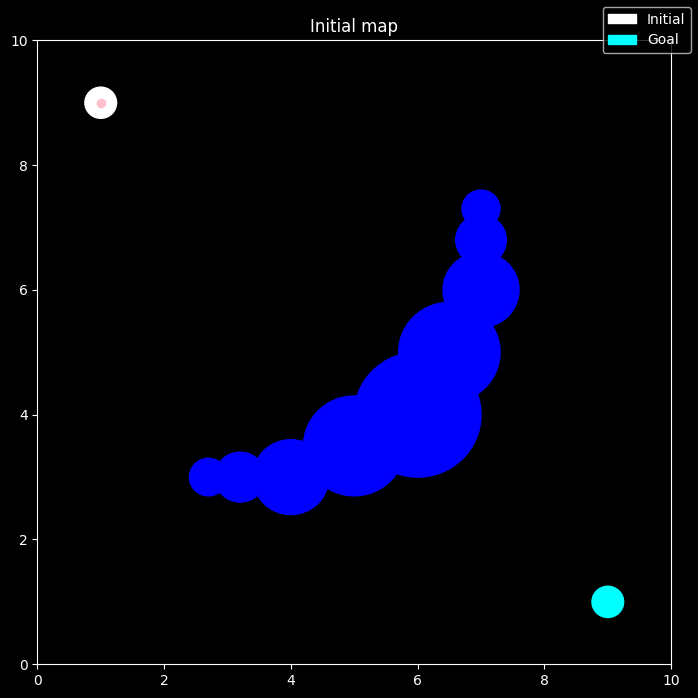

  0%|          | 0/1000 [00:00<?, ?it/s]

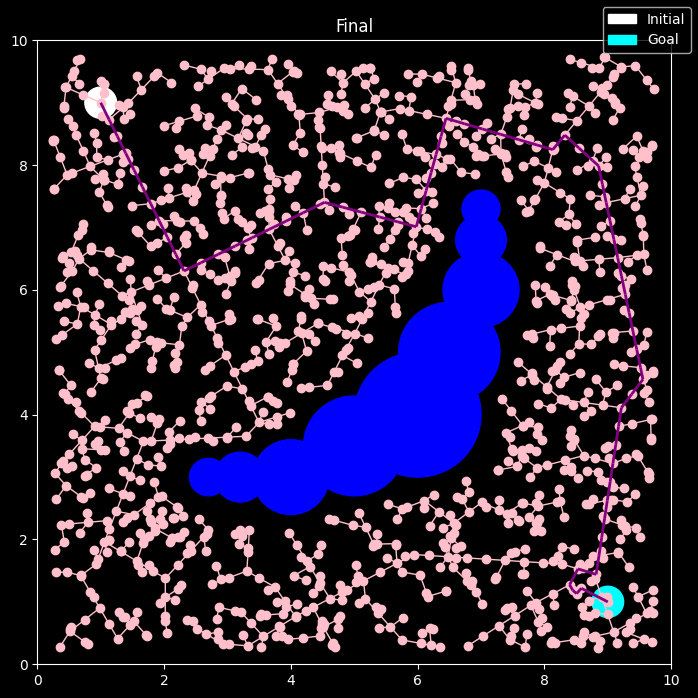

Saved GIF to 1.3.gif


In [22]:
class RRTSolver:
    def __init__(self, tree: Tree, env: Environment, robot: Robot, step_size: float = 0.1, max_iter: int = 1000, gif_generator: GIFGenerator = None):
        self.tree = tree
        self.env = env
        self.robot = robot
        self.step_size = step_size
        self.max_iter = max_iter
        self.gif_generator = gif_generator

    def solve(self, save_every: int, save_path: str):
        found_path = None
        for i in tqdm(range(self.max_iter)):
            new_found_path = self.step()
            if new_found_path is not None:
                if found_path is None:
                    found_path = new_found_path
                elif len(new_found_path) < len(found_path):
                        found_path = new_found_path
                found_path = new_found_path
            fig = self.env.draw(self.tree, found_path, title=f"Iteration {i}", show=False)
            if i % save_every == 0 and self.gif_generator is not None:
                self.gif_generator.add_frame(fig)
            plt.close()

        self.env.draw(self.tree, found_path, title="Final", show=True)
        if self.gif_generator is not None and save_path is not None:
            self.gif_generator.save(save_path)
    
    def extend(self, tree_node: Node, rand_state: State):
        tree_state = tree_node.state
        distance = (tree_state - rand_state).norm()
        max_step = distance // self.step_size
        states = [
            tree_state + (rand_state - tree_state) / distance * self.step_size * (i + 1) for i in range(0, int(max_step))
        ] + [rand_state]
        valid_states = []
        for state in states:
            self.robot.set_state(state)
            if self.env.check_collision(self.robot):
                break
            valid_states.append(state)

        parent = tree_node
        new_nodes = []
        for state in valid_states:
            node = Node(state, parent)
            self.tree.add(node)
            parent = node
            new_nodes.append(node)
        return new_nodes

    def check_goal(self, nodes: list[Node]):
        for node in nodes:
            self.robot.set_state(node.state)
            if self.env.reached_goal(self.robot):
                return node
        return None

    def step(self):
        def select_nearest_node(rand_state, nodes):
            return min(nodes, key=lambda node: (node.state - rand_state).norm())

        rand_state = self.env.generate_random_state(self.robot)
        tree_node = self.tree.select_node(policy=lambda nodes: select_nearest_node(rand_state, nodes))
        new_nodes = self.extend(tree_node, rand_state)
        dest_node =  self.check_goal(new_nodes)
        if dest_node is not None:
            return self.tree.get_path(dest_node)
        return None

gif_generator = GIFGenerator()
env = Environment.dummy()
init_state, goal_state = env.init_state, env.goal_state
tree = Tree(init_state)
env.draw(tree, title="Initial map", show=True)

solver = RRTSolver(tree, env, Robot(0.25, State.dummy()), step_size=0.3, max_iter=1000, gif_generator=gif_generator)
solver.solve(10, "1.3.gif")


Answer the following questions:
1. Is RRT more efficient than the ones given in 1.1 and 1.2? If so, describe what makes RRT more efficient.

RRT is more efficient than the ones given in 1.1 and 1.2. The reason is that RRT algorithm can explore the configuration space more efficiently. By selecting a closest node from random configuration, the tree tends to grow to largest voronoi region, which is unexplored area.

2. In what cases will the algorithm in 1.2 be more efficient than RRT?


If there are no obstacles, the algorithm in 1.2 will be more efficient than RRT because the algorithm in 1.2 always selects the node with the least straight-line distance to the goal. In this case, the algorithm in 1.2 will find the goal configuration faster than RRT.

## 2.0 Limitations of RRT*

### 2.1 RRT*

Here is a pseudocode for RRT*:

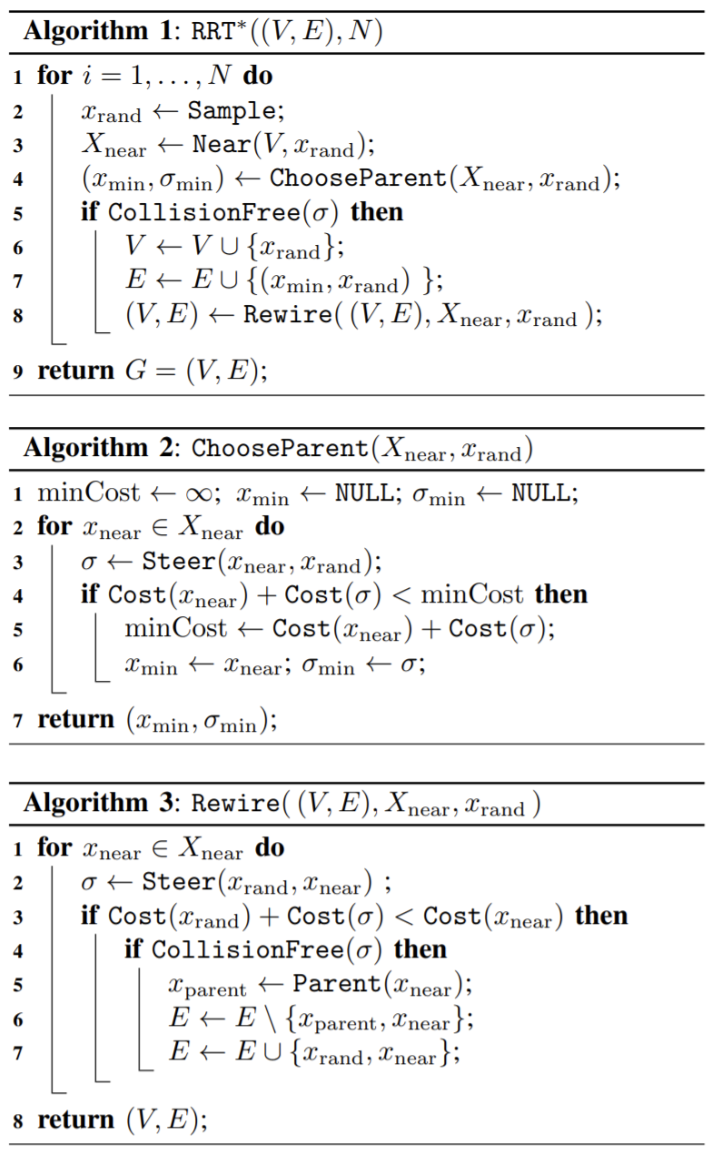

V - nodes in the tree  
E - edges in the tree  
N - the total number of iterations  
Steer - Equivalent to Extend function  
Cost(x) - cost from the initial configuration to x  
Near(x) - computes a set of configurations near x. It is computed by  
$$
\text{Near}(x) = \{x' \in V : \; ||x-x'|| \leq \gamma (\frac{\log n}{n})^{1/d}\}
$$
where n is the number of nodes in the tree, d is the dimensionality of the configuration space, and gamma is a user-defined constant

Implement RRT*.


In [ ]:
class RRTStarSolver:
    def __init__(self, tree: Tree, env: Environment, robot: Robot, step_size: float = 0.1, max_iter: int = 1000, gif_generator: GIFGenerator = None):
        self.tree = tree
        self.env = env
        self.robot = robot
        self.step_size = step_size
        self.max_iter = max_iter
        self.gif_generator = gif_generator

    def solve(self, save_every: int, save_path: str):
        found_path = None
        for i in tqdm(range(self.max_iter)):
            new_found_path = self.step()
            if new_found_path is not None:
                if found_path is None:
                    found_path = new_found_path
                elif len(new_found_path) < len(found_path):
                        found_path = new_found_path
                found_path = new_found_path
            fig = self.env.draw(self.tree, found_path, title=f"Iteration {i}", show=False)
            if i % save_every == 0 and self.gif_generator is not None:
                self.gif_generator.add_frame(fig)
            plt.close()

        self.env.draw(self.tree, found_path, title="Final", show=True)
        if self.gif_generator is not None and save_path is not None:
            self.gif_generator.save(save_path)
    
    def extend(self, tree_node: Node, rand_state: State):
        tree_state = tree_node.state
        distance = (tree_state - rand_state).norm()
        max_step = distance // self.step_size
        states = [
            tree_state + (rand_state - tree_state) / distance * self.step_size * (i + 1) for i in range(0, int(max_step))
        ] + [rand_state]
        valid_states = []
        for state in states:
            self.robot.set_state(state)
            if self.env.check_collision(self.robot):
                break
            valid_states.append(state)

        parent = tree_node
        new_nodes = []
        for state in valid_states:
            node = Node(state, parent)
            self.tree.add(node)
            parent = node
            new_nodes.append(node)
        return new_nodes

    def check_goal(self, nodes: list[Node]):
        for node in nodes:
            self.robot.set_state(node.state)
            if self.env.reached_goal(self.robot):
                return node
        return None

    def step(self):
        def select_nearest_node(rand_state, nodes):
            return min(nodes, key=lambda node: (node.state - rand_state).norm())

        rand_state = self.env.generate_random_state(self.robot)
        tree_node = self.tree.select_node(policy=lambda nodes: select_nearest_node(rand_state, nodes))
        new_nodes = self.extend(tree_node, rand_state)
        dest_node =  self.check_goal(new_nodes)
        if dest_node is not None:
            return self.tree.get_path(dest_node)
        return None

gif_generator = GIFGenerator()
env = Environment.dummy()
init_state, goal_state = env.init_state, env.goal_state
tree = Tree(init_state)
env.draw(tree, title="Initial map", show=True)

solver = RRTStarSolver(tree, env, Robot(0.25, State.dummy()), step_size=0.3, max_iter=1000, gif_generator=gif_generator)
solver.solve(10, "2.1.gif")


Is it faster than RRT? What is the most time-consuming procedure?

2.2 (Potentially) Improving RRT*
Suppose we have the following two functions:
CostLocal(x1, x2) - defined as a straight-line distance between configurations x1 and x2
CostGlobal(x) - defined as a straight-line distance from x to xgoal
In the ChooseParent function above, instead of choosing the one with the least cost, use the following to determine xmin:

xmin= argminx XnearCost(x) + CostLocal(x, xrand) + CostGlobal(x) 

In the Rewire function, use 
Cost(xrand) + CostLocal(x, xrand)
instead of using 
Cost(xrand) + Cost()
in Line 3, and skip the Steer operation. 

Answer the following questions.
Is this RRT* variant faster than standard RRT*? Why or why not?
How would you improve this variant?
